In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
##font = {'weight' : 'medium',
##       'size'   : 13}
#matplotlib.rc('font', **font)

from csr2d.beam_conversion import particle_group_to_bmad, bmad_to_particle_group
from pmd_beamphysics.plot import marginal_plot, density_plot
from csr2d.simple_track import track_a_bend, track_a_drift, track_a_bend_parallel, track_a_drift_parallel


#from csr2d.simple_track_numba import track_a_bend, track_a_drift

##from csr2d.csr_kick import calc_csr_kick  ## Obsolete
#from csr2d.kick import csr2d_kick_calc  ## Obsolete?

from csr2d.kick2 import csr2d_kick_calc, csr1d_steady_state_kick_calc

import time
import h5py

from pmd_beamphysics.interfaces.elegant import elegant_to_data
from pmd_beamphysics import ParticleGroup

import concurrent.futures as cf

import warnings
warnings.filterwarnings("ignore")

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

# Parameters

In [2]:
gamma = 9804
# gamma = 9.784756043574142e+03  # Glen

rho = 10.34 # Bend radius in m
LB = 0.5     # Bend length in m

# Desired beam optics at the END of the bend ( see Yunhai's 3D CSR paper )
beta_xf  = 5.19   # in m
alpha_xf = 0
eta_xf   = 0      # in m
etap_xf  = 0

beta_yf  = 12.28   # in m
alpha_yf = 0
eta_yf   = 0      # in m
etap_yf  = 0

# With the parameters above we can calculate (using Bmad)
# the required INITIAL beam optics at the BEGINNING of the bend
beta_x  = 5.22600574   # in m
alpha_x = 0.07195534
eta_x   = 0.01208662     # in m
etap_x  = -0.04833706

beta_y = 12.30035831    # in m
alpha_y = 0.04071661
eta_y   = 0             # in m
etap_y  = 0

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m
norm_emit_y = 1e-6           # in m
emit_y = norm_emit_y / gamma # in m

# Bunch length and energy spread
sigma_z  = 2e-5
sigma_delta = 5e-5   # a small value picked by Glen


# Total charge
Nb = 6.25e9
Q = e_charge * Nb


## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2

In [6]:
W0

3492835.4842369524

In [7]:
rho

10.34

In [8]:
r_e*Q/e_charge/gamma

1.7964225865718075e-09

# Beam definition

In [3]:
# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  


# Define an uncorrelated beam first
sigma_x = np.sqrt(emit_x * beta_x)
sigma_xp = np.sqrt(emit_x / beta_x)
sigma_y = np.sqrt(emit_y * beta_y)
sigma_yp = np.sqrt(emit_y / beta_y)

beam = np.zeros((6, Np))

beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

#beam[5] = np.zeros(Np)    # turn off initial energy spread

In [4]:
# Introduce coupling and dispersion 
r16 = eta_x
r26 = etap_x

r21 = (-1) * (alpha_x / beta_x) 

r36 = eta_y
r46 = etap_y

r43 = (-1) * (alpha_y / beta_y) 

# Apply coupling to the beam
# Be careful with the order of these lines...

beam[1] = beam[1] + r21 * beam[0] + r26 * beam[5]
beam[0] = beam[0] + r16 * beam[5]

beam[3] = beam[3] + r43 * beam[2] + r46 * beam[5]
beam[2] = beam[2] + r36 * beam[5]

In [8]:
# Check beam optics
P = bmad_to_particle_group(beam, p0c = p0c, t_ref = 0, charges = charges, verbose=False)
P.twiss()

{'alpha_x': 0.07140731799734733,
 'beta_x': 5.231423558032416,
 'gamma_x': 0.19212724680270407,
 'emit_x': 1.0187762035464371e-10,
 'eta_x': 0.012093798967067172,
 'etap_x': -0.04838054983616345,
 'norm_emit_x': 9.988082420656697e-07}

In [25]:
p0c

5009833679.739263

In [24]:
P['sigma_x'] *1e6

23.093935471585038

In [147]:
(max(P.p) -P0c)/P0c

0.00022463881633902485

In [16]:
(P.p -p0c)/p0c

array([ 5.54076189e-05,  2.90572447e-05,  2.81896665e-05, ...,
       -6.18641777e-05,  7.13567762e-05, -4.73253032e-05])

In [17]:
P['sigma_p']/p0c

4.998327898961826e-05

In [64]:
# Save the initial beam to run in Bmad
#P.write_bmad('Glen_beam_Np1M.txt',p0c = P0c, t_ref = 0)

# Main Loop

In [33]:
# Main switch
CSRon = True

In [5]:
def track_bend_with_2d_csr(Pin, p0c=None, gamma=None, L=0, g=0, g_err=0, N_step=20, s0=0, nz=200, nx=200, xlim=None, zlim=None,
                           map_f=map, CSR_on = True, CSR_1D_only = False, energy_kick_on=True,  xp_kick_on=True, bend_name='the bend', 
                           keep_Pin=True, debug=True, save_all_P=False, h5_save=None, parallel=True):

    Plist = []       # To save the beam at each step
    csr_data_list = []  # To save the wake and grid at each step
    slist = []      # To save the s position at each step
    s = s0
    
    if keep_Pin:
        Plist.append(Pin)
        slist.append(s0)
        if h5_save:
            print('Saving the initial beam into the h5 file...')
            group = h5.create_group(bend_name + str(0))
            group.attrs['s_position'] = s0
            Pin.write(group)
        
    if parallel:
        track = track_a_bend_parallel
    else:
        track = track_a_bend
    
    rho = 1/g    # rho can be negative     

    beam, charges = particle_group_to_bmad(Pin, p0c = p0c)
    
    #N_steps = int(np.floor(L/ds_step))
    ds_step = L/N_step

    for i in range(N_step):
        print('Tracking through', bend_name, 'in the', i+1 , "th step starting at s=" , s,'m' ) 

        ## track through a bend of length ds/2
        beam = track(beam, p0c = p0c, L=ds_step/2, theta = ds_step/2/rho, g_err=g_err)
    
        ## Calculate CSR kicks to xp and delta
        ####===================================
    
        if (CSR_on):
            
            if (CSR_1D_only):
                print('Applying 1D s-s kick...')
                csr_data = csr1d_steady_state_kick_calc(beam[4,:], charges, nz=nz, rho=rho, normalized_units=False)
                delta_kick = csr_data['denergy_ds']/(gamma*mec2)
                beam[5] = beam[5] + delta_kick * ds_step
                
            else:
                csr_data = csr2d_kick_calc(beam[4,:], beam[0,:], charges, gamma=gamma, rho=rho, 
                                           nz=nz, nx=nx, zlim=zlim, xlim=xlim,
                                           map_f = map_f, debug=debug)
                if (save_all_P):
                    csr_data_list.append(csr_data)
                              
                if (energy_kick_on):
                    print('Applying energy kick...')
                    delta_kick = csr_data['ddelta_ds'] 
                    #print('avg delta_kick:', np.mean(delta_kick), 'ds_step', ds_step)
                    #print('max delta_kick:', np.max(delta_kick), 'ds_step', ds_step)
                    #print('min delta_kick:', np.min(delta_kick), 'ds_step', ds_step)
                    beam[5] = beam[5] + delta_kick * ds_step
            
                if (xp_kick_on):
                    print('Applying xp_kick...')
                    xp_kick = csr_data['dxp_ds'] 
                    beam[1] = beam[1] + xp_kick * ds_step
    
        ####====================================

        ## track through a bend of length ds/2
        beam = track(beam, p0c = p0c, L=ds_step/2, theta = ds_step/2/rho, g_err=g_err)
    
        s += ds_step
    
        # save the beam and s at every step into a h5 file
        if h5_save:
            print('Saving beam into the h5 file...')
            P = bmad_to_particle_group(beam, p0c = p0c, t_ref = 0, charges = charges, verbose=False)
            group = h5.create_group(bend_name + str(i+1))
            group.attrs['s_position'] = s
            P.write(group)
    
        # save the beam and s at every step
        if save_all_P:
            P = bmad_to_particle_group(beam, p0c = p0c, t_ref = 0, charges = charges, verbose=False)
            Plist.append(P)
            slist.append(s)
    
    output = {}
    output['Pout'] = bmad_to_particle_group(beam, p0c = p0c, t_ref = 0, charges = charges, verbose=False)
    if save_all_P:
        output['csr_data_list'] = csr_data_list
        output['Plist'] = Plist
        output['slist'] = slist

    return output

In [87]:
haha = csr2d_kick_calc(beam[4,:], beam[0,:], charges, gamma=gamma, rho=rho, nz=100, nx=100, zlim=zlim, xlim=xlim,
                                     map_f = map)['ddelta_ds']
np.mean(haha)

-0.00024339146349971338

In [85]:
haha = csr1d_steady_state_kick_calc(beam[4,:], charges, nz=100, rho=rho, normalized_units=False)['denergy_ds']/(gamma*mec2)
np.mean(haha)

-0.00023810250379122656

In [27]:
rho

10.34

In [28]:
# Tracking bend for just one step

#factor = 8
#xlim =[-np.std(beam[0])*factor, np.std(beam[0])*factor]
#zlim =[-np.std(beam[4])*factor, np.std(beam[4])*factor]  

xlim=None
zlim=None


#h5 = h5py.File('test.h5','w')
with cf.ProcessPoolExecutor(max_workers=20) as executor:
    ob = track_bend_with_2d_csr(P, p0c=p0c, gamma=gamma, L=0.5, g=1/rho, g_err=0, N_step=1, s0=0, nz=500, nx=500, xlim=xlim, zlim=zlim, 
                                    map_f=map, CSR_on = True, CSR_1D_only = False, energy_kick_on=True, xp_kick_on=False,
                               bend_name='the bend', keep_Pin=True, debug=True, save_all_P=True, h5_save=False)
#h5.close()

Tracking through the bend in the 1 th step starting at s= 0 m
Depositing particles takes: 0.02150726318359375 s
Computing potential grids take: 0.035488128662109375 s
Convolution takes: 0.1451725959777832 s
Interpolation with map_coordinates takes: 0.2989494800567627 s
Applying energy kick...


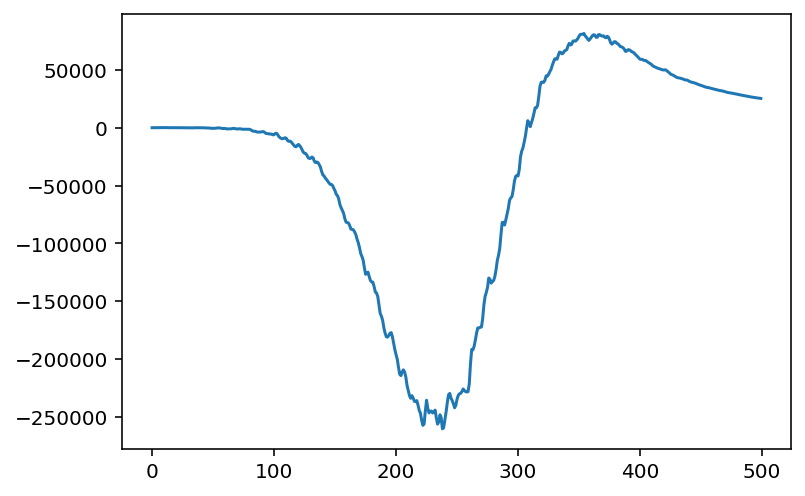

In [30]:
plt.plot(ob['csr_data_list'][0]['Ws_grid'][:,250])

Text(0.5, 1.0, 'CSR longitudinal kick along x=0\n (Yunhai 3D paper, s=0)')

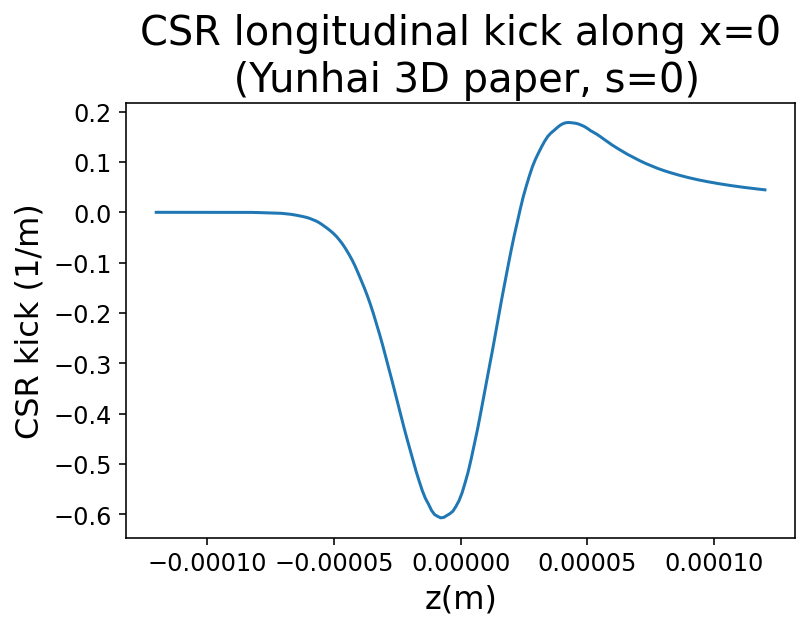

In [26]:
kick_factor = r_e*Q/e_charge/gamma

plt.plot(output['zvec'],output['Ws_grid'][:,100]*kick_factor  *P0c/W0)
plt.xlabel('z(m)', fontsize=16)
plt.ylabel('CSR kick (1/m)', fontsize=16)
plt.title('CSR longitudinal kick along x=0\n (Yunhai 3D paper, s=0)',  fontsize=20)
#plt.legend()

Text(0.5, 0.92, 'psi_s at the first step of chicane')

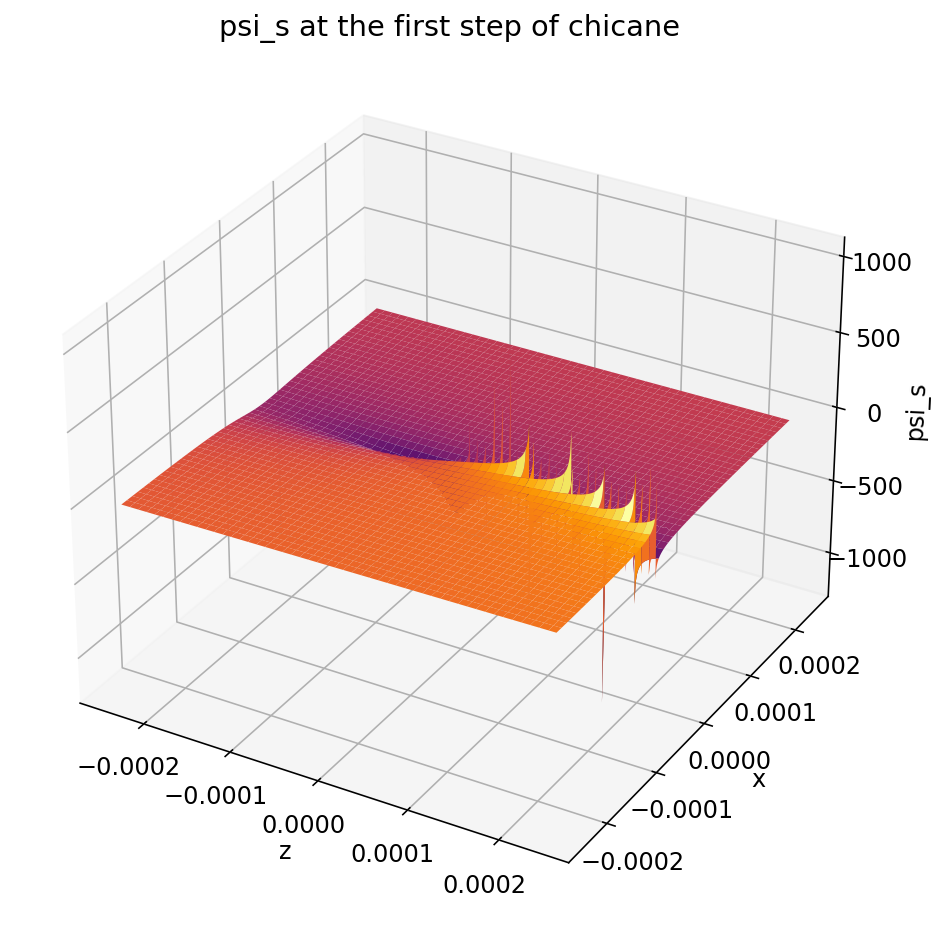

In [22]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(output['zvec2'], output['zvec2'])

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
#ax.contour3D(Z,X, psi_s_grid , 1000, cmap='inferno')
ax.plot_surface(Z,X, psi_s_grid , cmap='inferno')
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

In [99]:
#psi_s_grid = output['psi_s_grid']
#plt.imshow(psi_s_grid.T)

In [98]:
#plt.imshow(output['Ws_grid'].T)

In [97]:
#plt.imshow(output['charge_grid'].T)

In [46]:
P.twiss()

{'alpha_x': -0.0013860409913663593,
 'beta_x': 5.231185595000528,
 'gamma_x': 0.19116162157682517,
 'emit_x': 1.018816721245606e-10,
 'eta_x': -0.001423641727669508,
 'etap_x': 0.0009420070196684464,
 'norm_emit_x': 9.988455931443126e-07}

In [104]:
# Extracting data from all P takes time!!

from pmd_beamphysics import ParticleGroup, particle_paths
from h5py import File

def get_data(P):
 
    #out = P.twiss('xy')  # already a dictionary
    out = P.twiss('x')  # already a dictionary
  
    out['sigma_x'] = P['sigma_x'] 
    out['sigma_p'] = P['sigma_p'] 
    out['sigma_z'] = P['sigma_t'] *c_light
    return out

dat_list = []
slist_unordered = []

#filename = '../one_bend/bmad/beam_dump_csroff_Np1M.h5'
#filename = './chicane_both_kicks_on.h5'
#filename = './test.h5'
filename = './result_one_bend.h5'
#filename ='/global/cfs/cdirs/m669/cmayes/csr/chicane_test/save_beam_dump.h5' #Chris 3D
with File(filename, 'r') as h5:
    ppaths = list(h5)
    #ppaths = particle_paths(h5)   # Chris's
    
    for g in ppaths:
        P = ParticleGroup(h5[g])
        dat = get_data(P)
        dat_list.append(dat)
        slist_unordered.append(h5[g].attrs['s_position'])   # Comment out if Chris's

In [69]:
dat_list[0]

{'alpha_x': 0.07140731799734733,
 'beta_x': 5.231423558032416,
 'gamma_x': 0.19212724680270407,
 'emit_x': 1.0187762035464371e-10,
 'eta_x': 0.012093798967067172,
 'etap_x': -0.04838054983616345,
 'norm_emit_x': 9.988082420656697e-07,
 'sigma_x': 2.309393547158504e-05,
 'sigma_p': 250407.91450599342,
 'sigma_z': 2.000893619118076e-05}

In [105]:
## New method: load all beams pre-saved in a h5 file
beta_x_list_temp = [dat_list[i]['beta_x'] for i in range(len(dat_list))]
eta_x_list_temp = [dat_list[i]['eta_x'] for i in range(len(dat_list))]
beamsize_x_list_temp = [dat_list[i]['sigma_x'] for i in range(len(dat_list))]
pro_emit_x_list_temp = [dat_list[i]['norm_emit_x'] for i in range(len(dat_list))]
sigma_p_list_temp = [dat_list[i]['sigma_p'] for i in range(len(dat_list))]
sigma_z_list_temp = [dat_list[i]['sigma_z'] for i in range(len(dat_list))]

slist = sorted(slist_unordered)
beta_x_list = [x for _,x in sorted(zip(slist_unordered, beta_x_list_temp))]
eta_x_list = [x for _,x in sorted(zip(slist_unordered, eta_x_list_temp))]
beamsize_x_list = [x for _,x in sorted(zip(slist_unordered, beamsize_x_list_temp))]
pro_emit_x_list = [x for _,x in sorted(zip(slist_unordered, pro_emit_x_list_temp))]
sigma_p_list = [x for _,x in sorted(zip(slist_unordered, sigma_p_list_temp))]
sigma_z_list = [x for _,x in sorted(zip(slist_unordered, sigma_z_list_temp))]

In [12]:
# Old Method
pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in Plist]
beta_x_list = [P.twiss()['beta_x'] for P in Plist]
alpha_x_list = [P.twiss()['alpha_x'] for P in Plist]
eta_x_list = [P.twiss()['eta_x'] for P in Plist]
beamsize_x_list = [P['sigma_x'] for P in Plist]
sigma_p_list = [P['sigma_p'] for P in Plist]

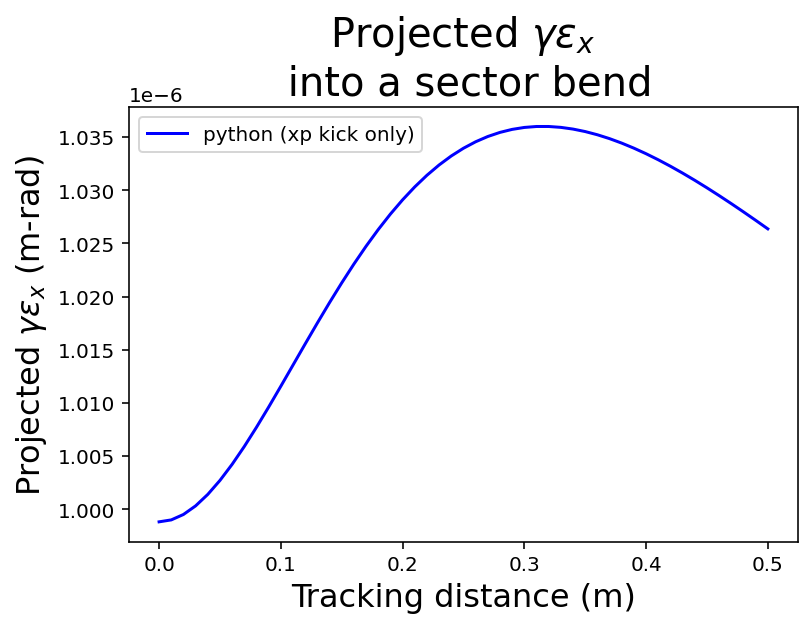

In [102]:
plt.plot(slist, pro_emit_x_list, label = 'python (xp kick only)',color = 'b');

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('Projected $\gamma\epsilon_{x}$ (m-rad)', fontsize=16)
plt.title('Projected $\gamma\epsilon_{x}$ \n into a sector bend', fontsize=20)
plt.legend()

In [103]:
pro_emit_x_list_1D = pro_emit_x_list.copy()

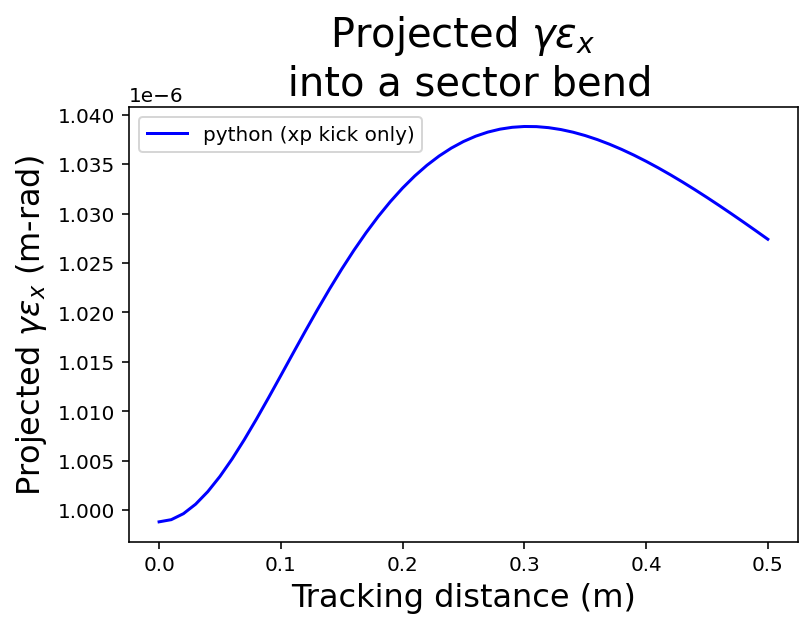

In [106]:
plt.plot(slist, pro_emit_x_list, label = 'python (xp kick only)',color = 'b');

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('Projected $\gamma\epsilon_{x}$ (m-rad)', fontsize=16)
plt.title('Projected $\gamma\epsilon_{x}$ \n into a sector bend', fontsize=20)
plt.legend()

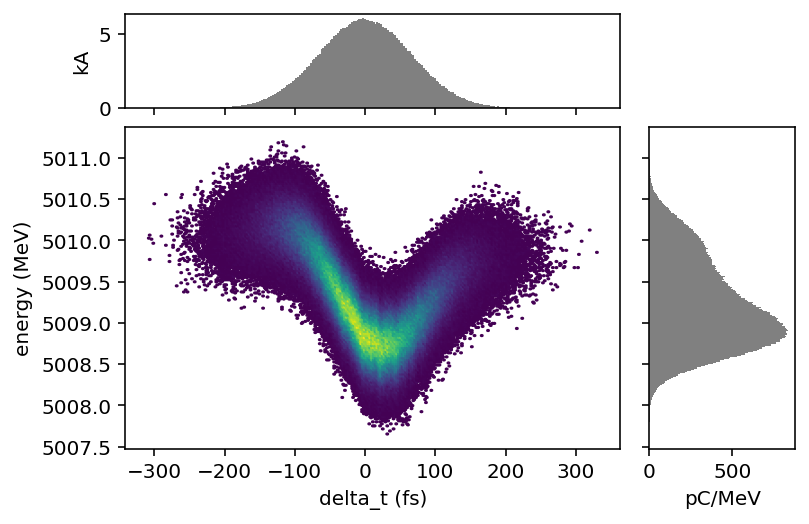

In [39]:
ob['Pout'].plot('delta_t', 'energy', bins=250)

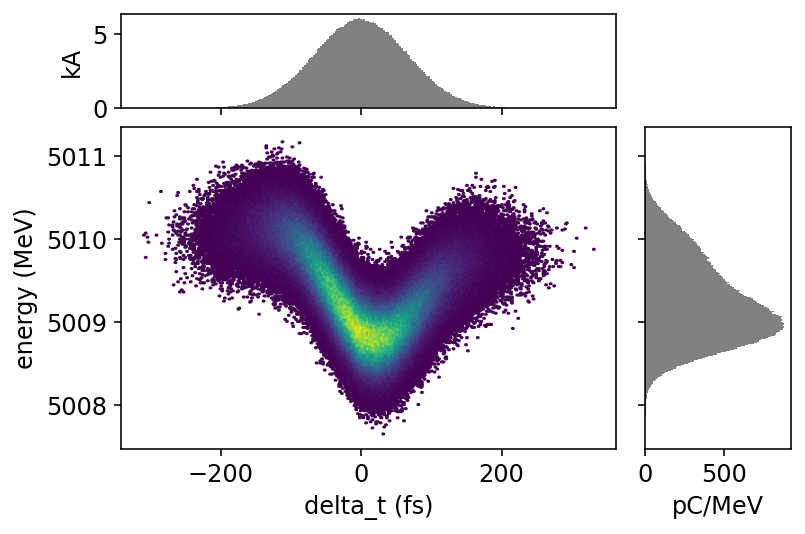

In [80]:
Plist[-1].plot('delta_t', 'energy', bins=250)

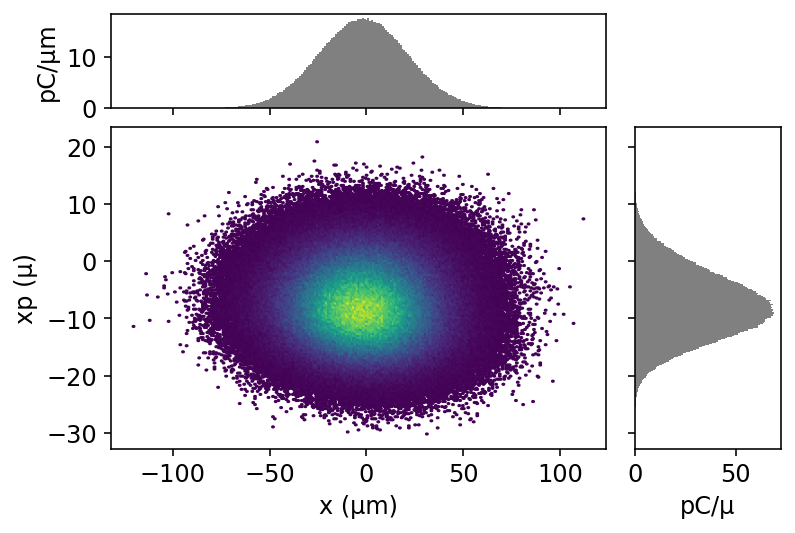

In [81]:
Plist[-1].plot('x', 'xp', bins=250)

## Import Tao results 

In [40]:
from pmd_beamphysics import ParticleGroup, particle_paths
from h5py import File

#filename = './bmad/beam_dump_csroff_Np1M.h5'
filename = './bmad/beam_dump_csron_Np1M_Nb200.h5'
with File(filename, 'r') as h5:
    ppaths = particle_paths(h5)
    PG = [ParticleGroup(h5[g]) for g in ppaths]
    
def get_stat(key):
    return [P[key] for P in PG]

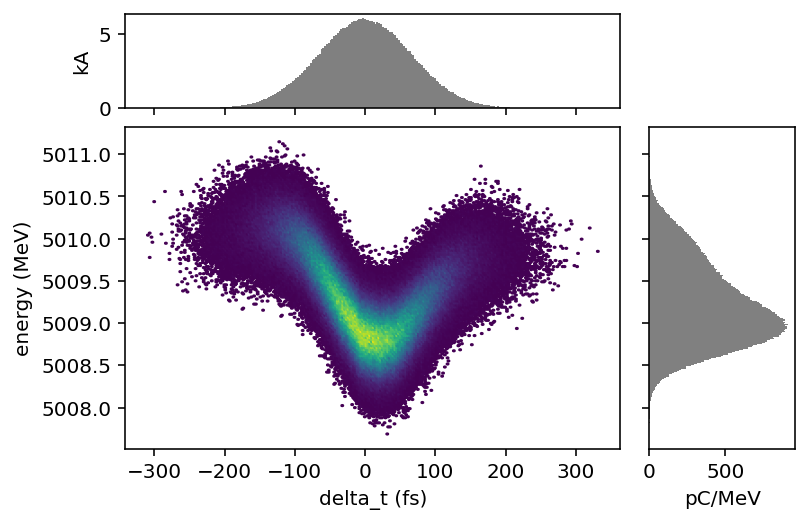

In [14]:
PG[-1].plot('delta_t', 'energy', bins=250)

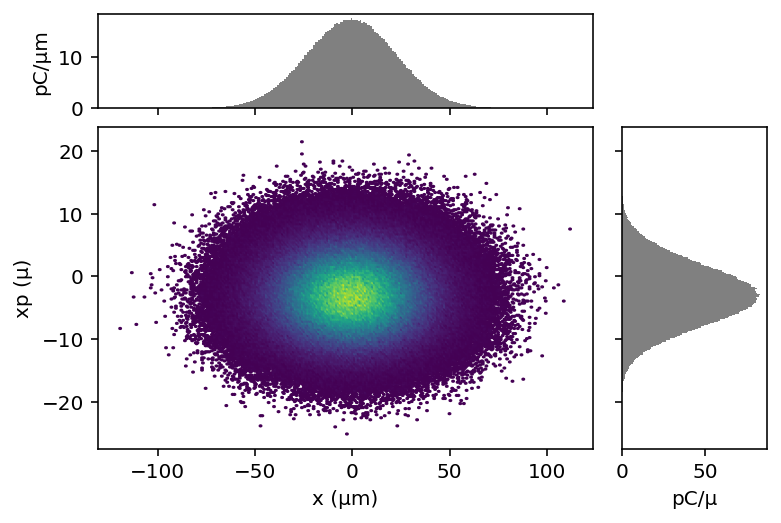

In [15]:
PG[-1].plot('x', 'xp', bins=250)

In [41]:
tao_pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in PG]
tao_beta_x_list = [P.twiss()['beta_x'] for P in PG]
tao_alpha_x_list = [P.twiss()['alpha_x'] for P in PG]
tao_eta_x_list = [P.twiss()['eta_x'] for P in PG]
tao_beamsize_x_list = [P['sigma_x'] for P in PG]
tao_sigma_p_list = [P['sigma_p'] for P in PG]

## Import Elegant results

In [42]:
from pmd_beamphysics.interfaces.elegant import elegant_to_data
from pmd_beamphysics import ParticleGroup

In [43]:
locationList = ['M0',\
                'M1','M2','M3','M4','M5','M6','M7','M8','M9','M10',\
               'M11','M12','M13','M14','M15','M16','M17','M18','M19','M20',\
               'M21','M22','M23','M24','M25','M26','M27','M28','M29','M30',\
               'M31','M32','M33','M34','M35','M36','M37','M38','M39','M40',\
               'M41','M42','M43','M44','M45','M46','M47','M48','M49','M50']

def elegant_beam(location):
    beam_dir = '/global/homes/w/wlou1991/CSR2D/elegant/results_Np1M_Nb1000/'
    OUTFILE= beam_dir + locationList[location-1]+'.out'
    print('Filename: ' + OUTFILE)
    DAT = elegant_to_data(OUTFILE, charge = 1.0013603962588557E-09)
    P1 = ParticleGroup(data=DAT)
    Palive = P1.where(P1['status'] == 1)
    return Palive

# OBSOLETE (slow to convert sdds files to h5 files)
#PE = [elegant_beam(i) for i in range(1,51)]

In [44]:
# CSR on
#PE = [ParticleGroup(f'/global/homes/w/wlou1991/CSR2D/elegant/results_Np1M_Nb1000/M{i}.out.h5') for i in range(0,51)]
PE = [ParticleGroup(f'./elegant/results_Np1M_Nb1000/M{i}.out.h5') for i in range(0,51)]

In [128]:
# CSR off
#PE = [ParticleGroup(f'/global/homes/w/wlou1991/CSR2D/elegant/results_Np1M_csroff/M{i}.out.h5') for i in range(0,51)]
PE = [ParticleGroup(f'./elegant/results_Np1M_csroff/M{i}.out.h5') for i in range(0,51)]

In [45]:
eleg_pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in PE]
eleg_beta_x_list = [P.twiss()['beta_x'] for P in PE]
eleg_alpha_x_list = [P.twiss()['alpha_x'] for P in PE]
eleg_eta_x_list = [P.twiss()['eta_x'] for P in PE]
eleg_beamsize_x_list = [P['sigma_x'] for P in PE]
eleg_sigma_p_list = [P['sigma_p'] for P in PE]

# Load Glen's Matlab result

In [74]:
matlab_pro_emit_x_list = np.loadtxt('Glen_matlab_results/emit_2ss.txt')[1]
#matlab_pro_emit_x_list = np.loadtxt('Glen_matlab_results/emit_2a_ss.txt')[51:102]
len(matlab_pro_emit_x_list)

51

# Plotting

## CSR on plots

In [110]:
font = {'weight' : 'medium',
        'size'   : 12}

matplotlib.rc('font', **font)

In [75]:
offset = pro_emit_x_list[0]-matlab_pro_emit_x_list[0]

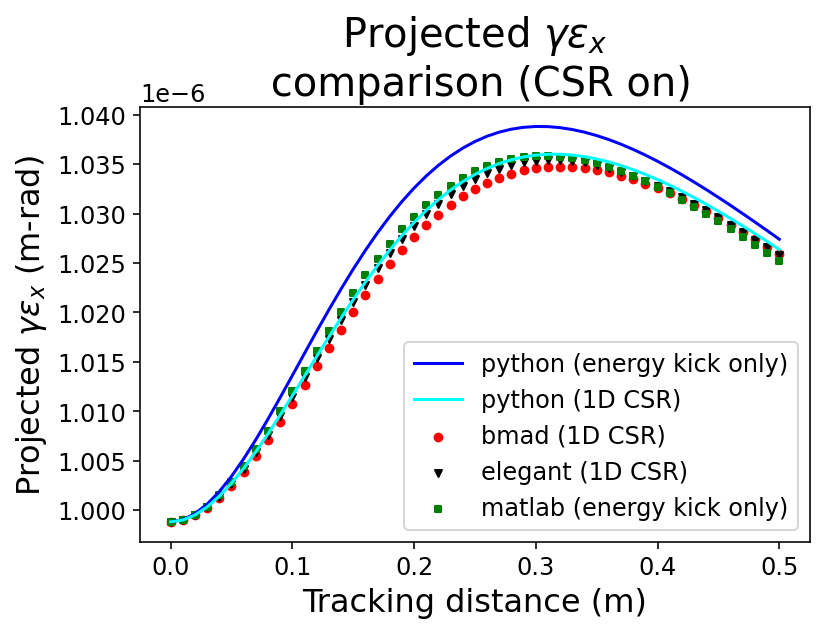

In [113]:
plt.plot(slist, pro_emit_x_list, label = 'python (energy kick only)',color='b')
plt.plot(slist, pro_emit_x_list_1D, label = 'python (1D CSR)',color='cyan')
plt.scatter(slist, tao_pro_emit_x_list, label = 'bmad (1D CSR)',color='r',marker = '.',s=60)
plt.scatter(slist, eleg_pro_emit_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)
plt.scatter(slist,matlab_pro_emit_x_list + offset, label = 'matlab (energy kick only)',color='g', marker ='s', s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'Projected $\gamma\epsilon_{x}$ (m-rad)', fontsize=16)
plt.title('Projected $\gamma\epsilon_{x}$\n comparison (CSR on)',  fontsize=20)
plt.legend()

In [35]:
offset = pro_emit_x_list[0]-matlab_pro_emit_x_list[0]

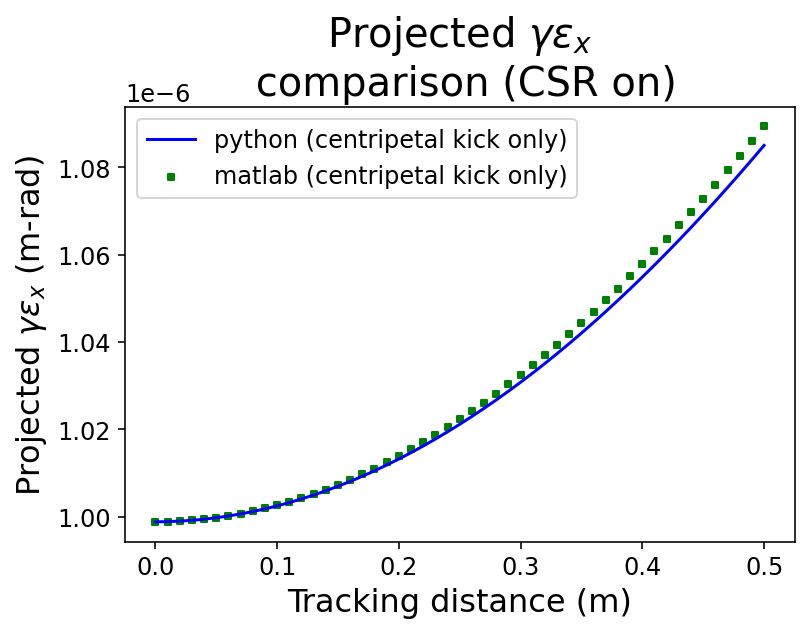

In [39]:
plt.plot(slist, pro_emit_x_list, label = 'python (centripetal kick only)',color='b')

plt.scatter(slist,matlab_pro_emit_x_list + offset, label = 'matlab (centripetal kick only)',color='g', marker ='s', s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'Projected $\gamma\epsilon_{x}$ (m-rad)', fontsize=16)
plt.title('Projected $\gamma\epsilon_{x}$\n comparison (CSR on)',  fontsize=20)
plt.legend()

In [95]:
offset = pro_emit_x_list[0]-matlab_pro_emit_x_list[0]

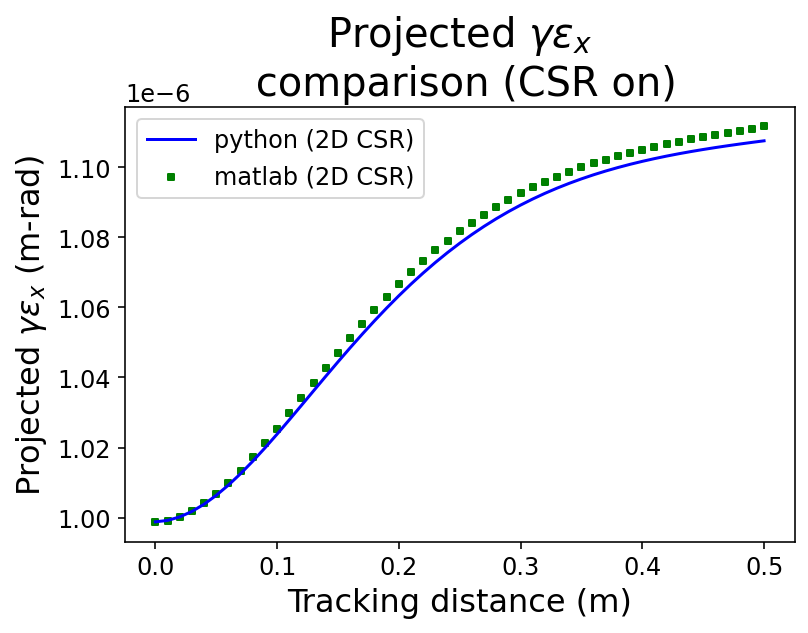

In [96]:
plt.plot(slist, pro_emit_x_list, label = 'python (2D CSR)',color='b')

plt.scatter(slist,matlab_pro_emit_x_list + offset, label = 'matlab (2D CSR)',color='g', marker ='s', s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'Projected $\gamma\epsilon_{x}$ (m-rad)', fontsize=16)
plt.title('Projected $\gamma\epsilon_{x}$\n comparison (CSR on)',  fontsize=20)
plt.legend()

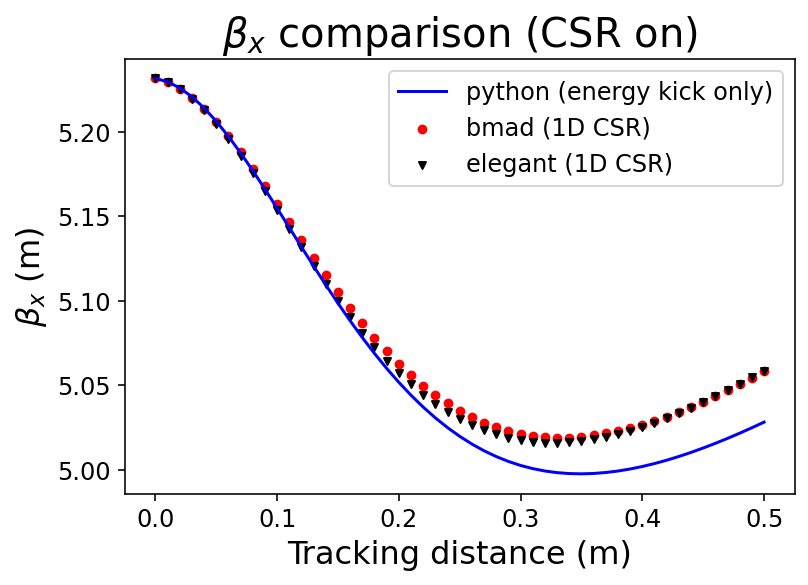

In [105]:
plt.plot(slist, beta_x_list, label = 'python (energy kick only)',color='b')
plt.scatter(slist, tao_beta_x_list, label = 'bmad (1D CSR)',color='r',marker = '.',s=60)
plt.scatter(slist, eleg_beta_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\beta_x$ (m)', fontsize=16)
plt.title(r'$\beta_x$ comparison (CSR on)', fontsize=20)
plt.legend()

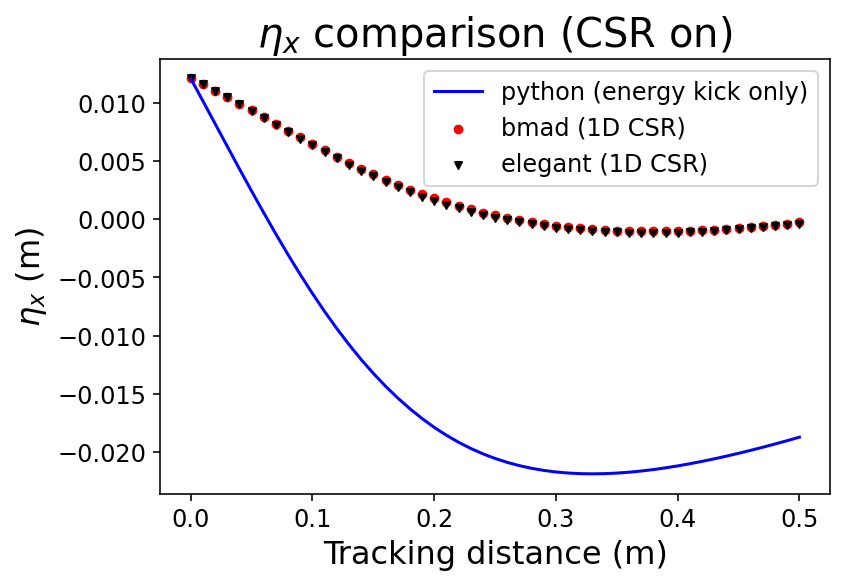

In [92]:
plt.plot(slist, eta_x_list, label = 'python (energy kick only)', color='b')
plt.scatter(slist, tao_eta_x_list, label = 'bmad (1D CSR)',color='r',marker = '.',s=60)
plt.scatter(slist, eleg_eta_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\eta_x$ (m)', fontsize=16)
plt.title(r'$\eta_x$ comparison (CSR on)', fontsize=20)
plt.legend()

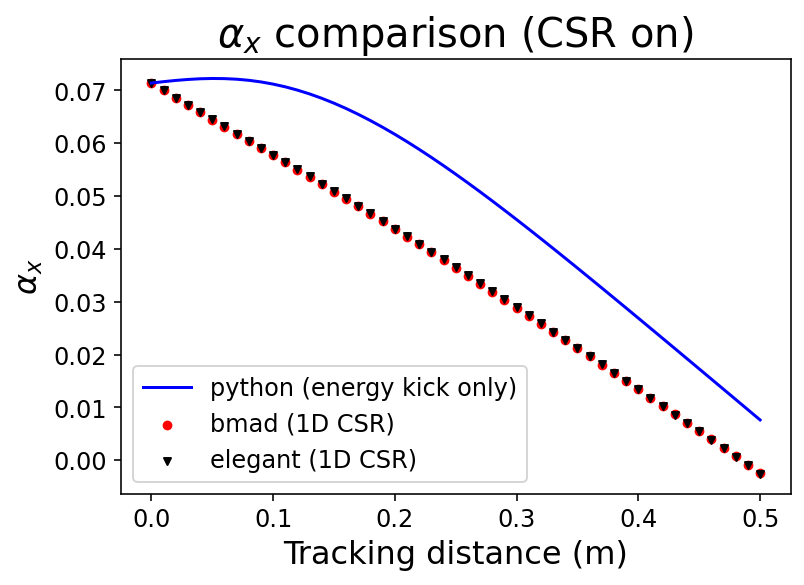

In [95]:
plt.plot(slist, alpha_x_list, label = 'python (energy kick only)', color='b')
plt.scatter(slist, tao_alpha_x_list, label = 'bmad (1D CSR)',color='r',marker = '.',s=60)
plt.scatter(slist, eleg_alpha_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\alpha_x$', fontsize=16)
plt.title(r'$\alpha_x$ comparison (CSR on)', fontsize=20)
plt.legend()

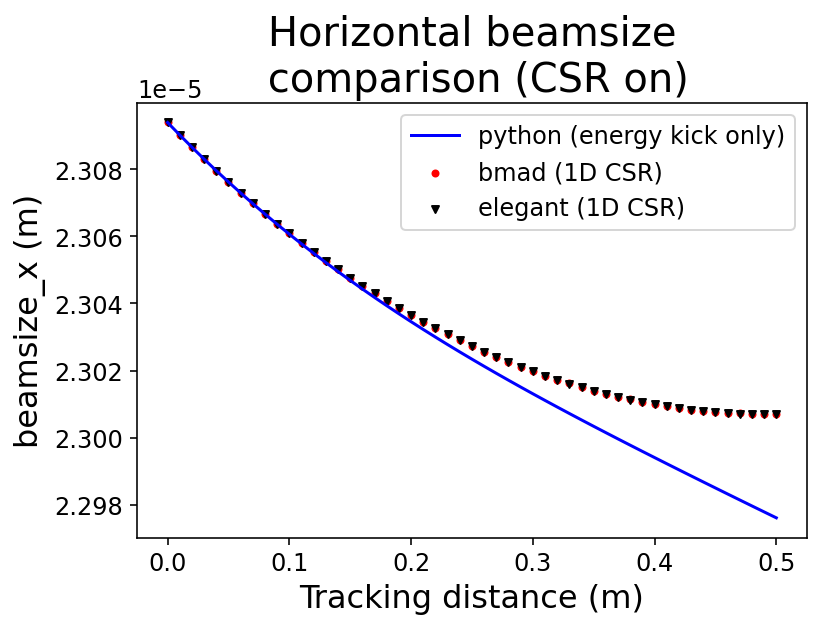

In [97]:
plt.plot(slist, beamsize_x_list, label = 'python (energy kick only)',color='b')
plt.scatter(slist, tao_beamsize_x_list, label = 'bmad (1D CSR)',color='r',marker = '.')
plt.scatter(slist, eleg_beamsize_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('beamsize_x (m)', fontsize=16)
plt.title('Horizontal beamsize\n comparison (CSR on)', fontsize=20)
plt.legend()

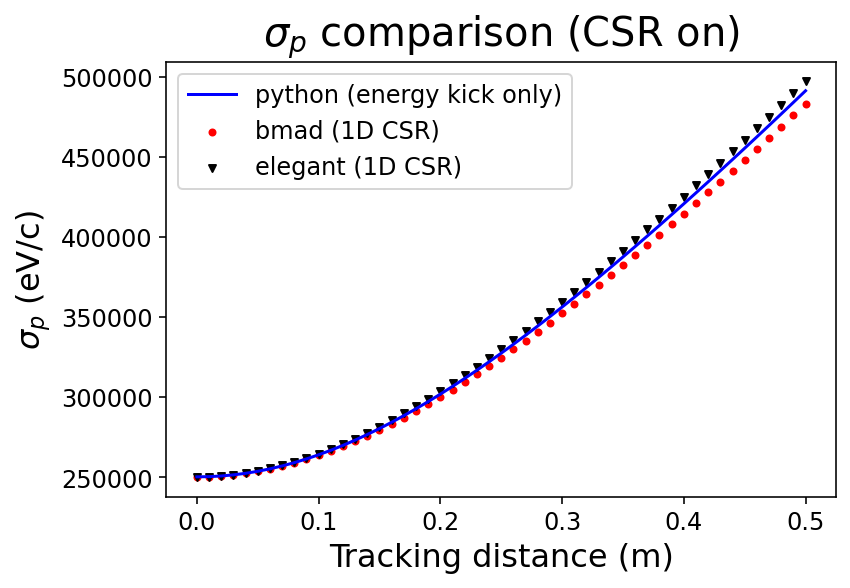

In [107]:
plt.plot(slist, sigma_p_list, label = 'python (energy kick only)',color='b')
plt.scatter(slist, tao_sigma_p_list, label = 'bmad (1D CSR)',color='r',marker = '.')
plt.scatter(slist, eleg_sigma_p_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\sigma_{p}$ (eV/c)', fontsize=16)
plt.title(r'$\sigma_{p}$ comparison (CSR on)', fontsize=20)
plt.legend()

## CSR off plots

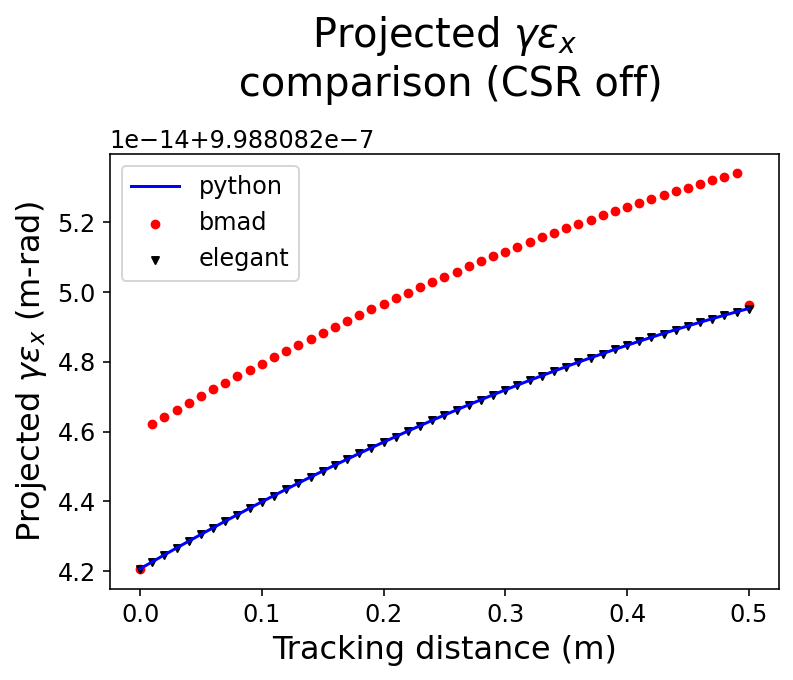

In [148]:
plt.plot(slist, pro_emit_x_list, label = 'python',color='b')
plt.scatter(slist, tao_pro_emit_x_list, label = 'bmad',color='r',marker = '.',s=60)
plt.scatter(slist, eleg_pro_emit_x_list, label = 'elegant',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('Projected $\gamma\epsilon_{x}$ (m-rad)', fontsize=16)
plt.title('Projected $\gamma\epsilon_{x}$\n comparison (CSR off)\n',  fontsize=20)
plt.legend()

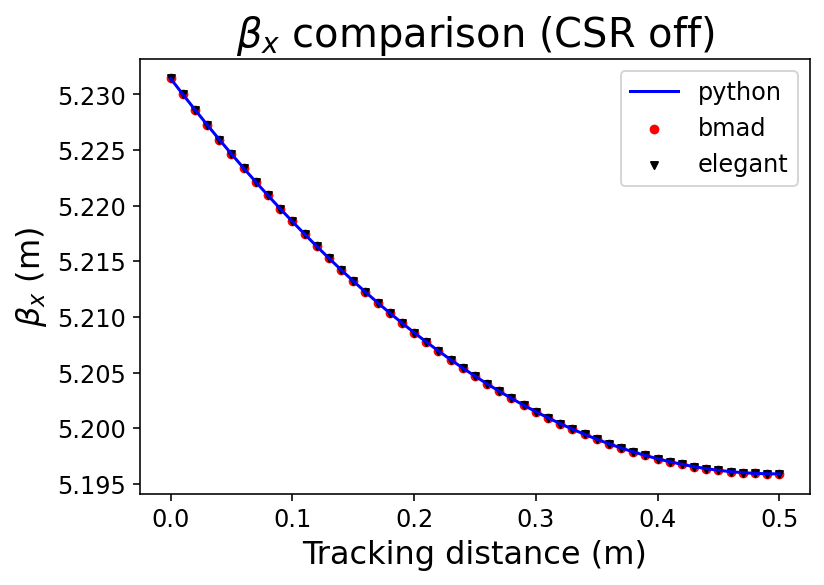

In [152]:
plt.plot(slist, beta_x_list, label = 'python',color='b')
plt.scatter(slist, tao_beta_x_list, label = 'bmad',color='r',marker = '.',s=60)
plt.scatter(slist, eleg_beta_x_list, label = 'elegant',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\beta_x$ (m)', fontsize=16)
plt.title(r'$\beta_x$ comparison (CSR off)', fontsize=20)
plt.legend()

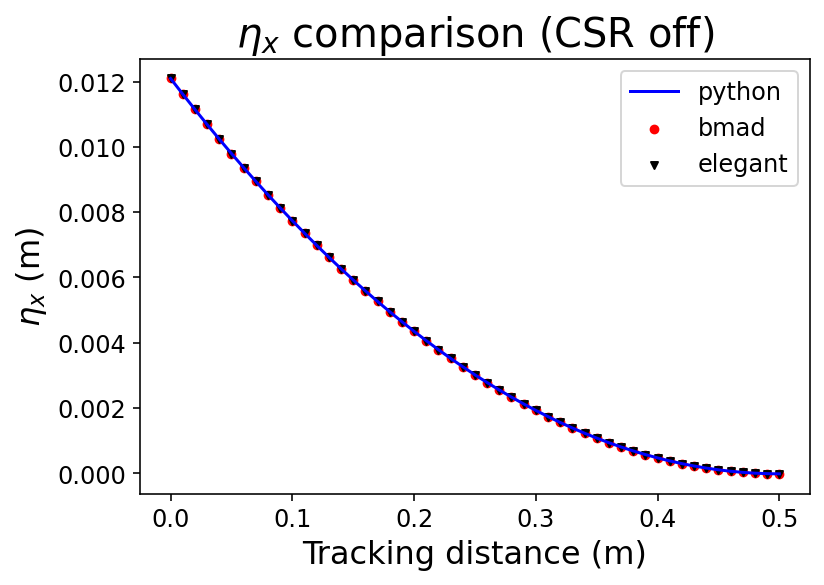

In [155]:
plt.plot(slist, eta_x_list, label = 'python', color='b')
plt.scatter(slist, tao_eta_x_list, label = 'bmad',color='r',marker = '.',s=60)
plt.scatter(slist, eleg_eta_x_list, label = 'elegant',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('$\eta_x$ (m)', fontsize=16)
plt.title('$\eta_x$ comparison (CSR off)', fontsize=20)
plt.legend()

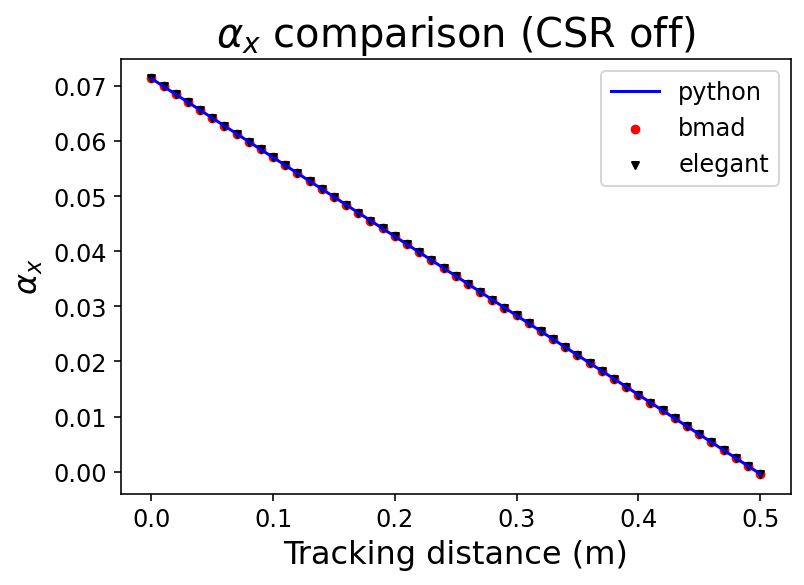

In [135]:
plt.plot(slist, alpha_x_list, label = 'python', color='b')
plt.scatter(slist, tao_alpha_x_list, label = 'bmad',color='r',marker = '.',s=60)
plt.scatter(slist, eleg_alpha_x_list, label = 'elegant',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\alpha_x$', fontsize=16)
plt.title(r'$\alpha_x$ comparison (CSR off)', fontsize=20)
plt.legend()

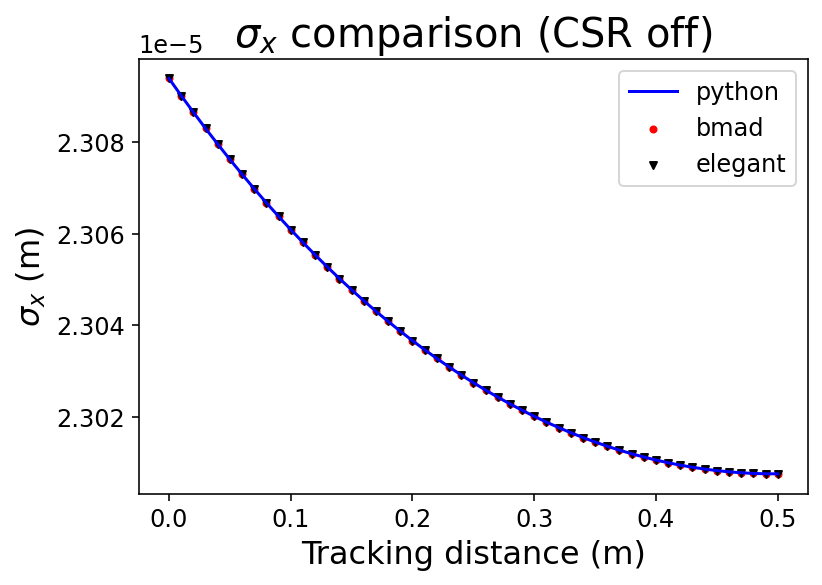

In [146]:
plt.plot(slist, beamsize_x_list, label = 'python',color='b')
plt.scatter(slist, tao_beamsize_x_list, label = 'bmad',color='r',marker = '.')
plt.scatter(slist, eleg_beamsize_x_list, label = 'elegant',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('$\sigma_x$ (m)', fontsize=16)
plt.title('$\sigma_x$ comparison (CSR off)', fontsize=20)
plt.legend()

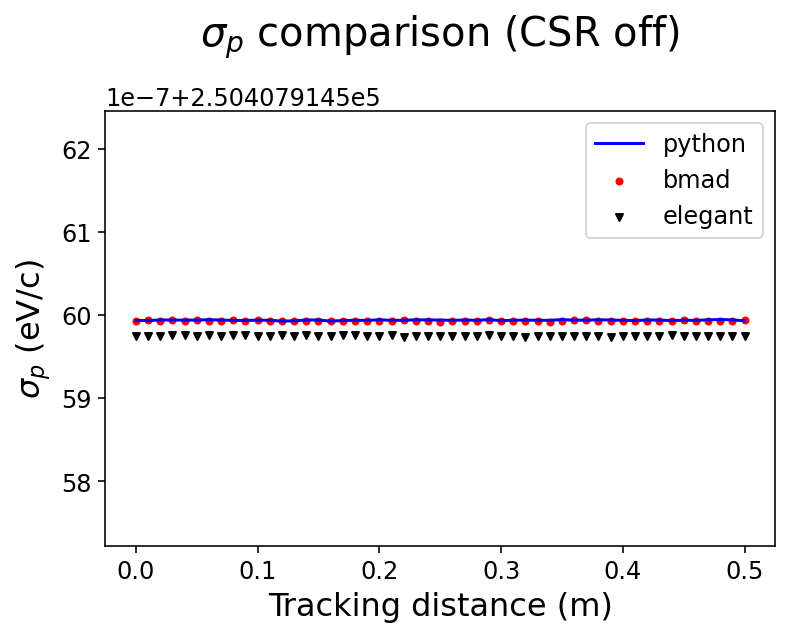

In [147]:
plt.plot(slist, sigma_p_list, label = 'python',color='b')
plt.scatter(slist, tao_sigma_p_list, label = 'bmad',color='r',marker = '.')
plt.scatter(slist, eleg_sigma_p_list, label = 'elegant',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('$\sigma_{p}$ (eV/c)', fontsize=16)
plt.title('$\sigma_{p}$ comparison (CSR off)\n', fontsize=20)
plt.legend()

### Phase space plots

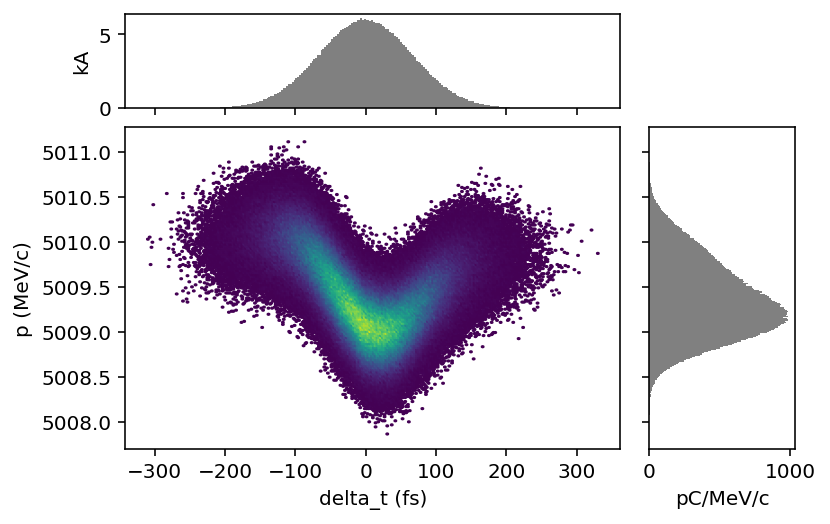

In [110]:
Plist[40].plot('delta_t', 'p', bins=250)

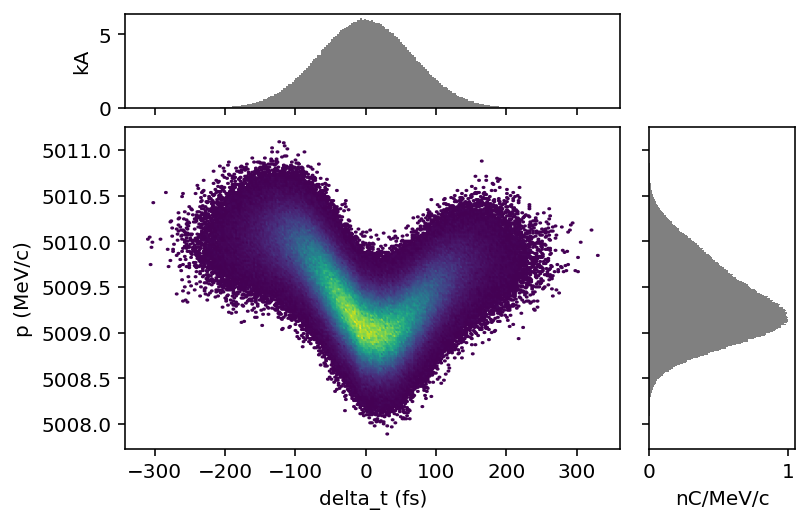

In [111]:
PG[40].plot('delta_t', 'p', bins=250)

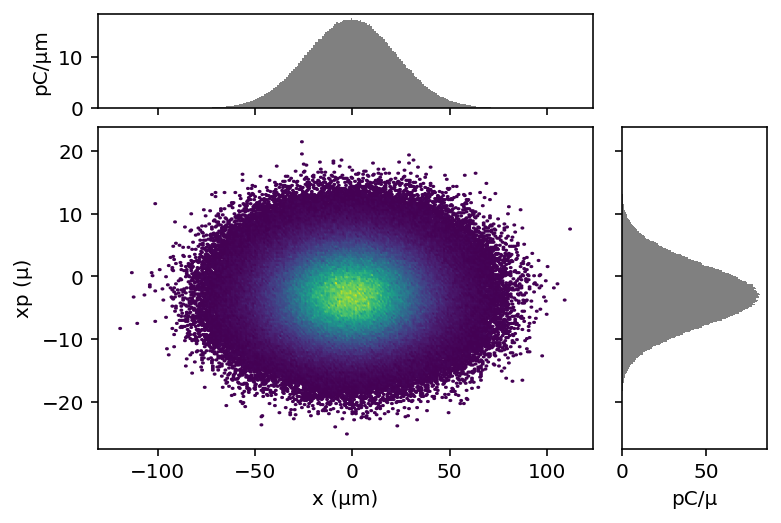

In [117]:
PE[50].plot('x', 'xp', bins=250)

## Save files

In [150]:
np.savetxt('slist.txt', slist)

In [147]:
np.savetxt('pro_emit_x_list.txt', pro_emit_x_list)
np.savetxt('beta_x_list.txt', beta_x_list)
np.savetxt('alpha_x_list.txt', alpha_x_list)
np.savetxt('eta_x_list.txt', eta_x_list)
np.savetxt('beamsize_x_list.txt', beamsize_x_list)

In [148]:
np.savetxt('tao_pro_emit_x_list.txt', tao_pro_emit_x_list)
np.savetxt('tao_beta_x_list.txt', tao_beta_x_list)
np.savetxt('tao_alpha_x_list.txt', tao_alpha_x_list)
np.savetxt('tao_eta_x_list.txt', tao_eta_x_list)
np.savetxt('tao_beamsize_x_list.txt', tao_beamsize_x_list)

In [149]:
np.savetxt('eleg_pro_emit_x_list.txt', eleg_pro_emit_x_list)
np.savetxt('eleg_beta_x_list.txt', eleg_beta_x_list)
np.savetxt('eleg_alpha_x_list.txt', eleg_alpha_x_list)
np.savetxt('eleg_eta_x_list.txt', eleg_eta_x_list)
np.savetxt('eleg_beamsize_x_list.txt', eleg_beamsize_x_list)

## Check emittance

In [95]:
temp = np.array([all_output[i]['Ws_grid'] for i in range(len(all_output))])
np.save('Ws_grid_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [96]:
temp = np.array([all_output[i]['Wx_grid'] for i in range(len(all_output))])
np.save( 'Wx_grid_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [97]:
temp = np.array([all_output[i]['zvec'] for i in range(len(all_output))])
np.save( 'zvec_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [98]:
temp = np.array([all_output[i]['xvec'] for i in range(len(all_output))])
np.save( 'xvec_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [99]:
np.save( 'slist_0.5m_50steps.npy', slist, allow_pickle=True)

In [4]:
def projected_emit_x(beam):
    SS = np.cov(beam)
    s00 = SS[0][0] - SS[0][5]*SS[0][5] / SS[5][5]
    s01 = SS[0][1] - SS[0][5]*SS[1][5] / SS[5][5]
    s11 = SS[1][1] - SS[1][5]*SS[1][5] / SS[5][5]

    return np.sqrt(s00*s11 - s01**2)

In [5]:
print(emit_x)          # desired
projected_emit_x(beam) # from the beam

1.0199918400652795e-10


1.0187762619965156e-10